In [6]:
#!pip install seaborn

In [7]:
import numpy as np

In [8]:
import pandas as pd

In [9]:
import yfinance as yf

In [18]:

import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
RISKY_ASSETS= ["GOOG","FB"]
SHARES=[5,5]
START_DATE = "2018-01-01"
END_DATE="2021-07-08"
T=1
N_SIMS = 10**5

In [12]:
df = yf.download(RISKY_ASSETS, start=START_DATE,
 end=END_DATE, adjusted=True)

[*********************100%***********************]  2 of 2 completed


<AxesSubplot:title={'center':'GOOG vs. FB returns: 2018-01-01 - 2021-07-08'}, xlabel='Date'>

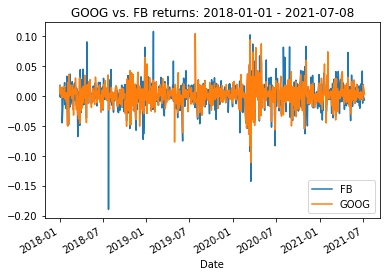

In [23]:
#calculamos el daily returns
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()
plot_title = f'{" vs. ".join(RISKY_ASSETS)} returns: {START_DATE} - {END_DATE}'
returns.plot(title=plot_title)


In [25]:
returns.corr()

,FB,GOOG
FB,1.000000,0.692526
GOOG,0.692526,1.000000


Hay dos formas de calcular el VaR:
    - Calcular el VaR de los precios: Usando el Nro de shares y asset prices, podemos calcular el valor del profolio,
        y es posible valuar X dias hacia delante.
    - Calcular el VaR de los retornos: Using percentage weights

In [26]:
# la correlacion es de 0.69

In [28]:
# calculamos la covaraince-matrix
cov_mat = returns.cov()
cov_mat

,FB,GOOG
FB,0.000543,0.000306
GOOG,0.000306,0.000361


Monte Carlo para determinar el precio de los assets usa variables random basadas en distribucion normal.
Para el caso de calcular el VaR, necesitamos ver si los assets de nuestro portfolio estan correlacionados.
Entonces calculamos la covariance Matrix historica, usando la descomposicion de Cholesky,
y multiplicamos el resultado por la matrix de las variables random.
De esta forma, agregamos correlacion a las random variables generadas.

O sea calculamos la matriz de covariancia, le aplicamos decomposicion de cholesky,
luego a la matriz con los retornos normal-distribution le aplicamos la matriz de cholesky, que nos da una
matriz similar correlacion a nuestros stocks reales.

Otra forma de generar random variables correlacionados, es usar "Singular Value decomposition SVD" en 
vez de cholesky (np.linalg.svd)


In [30]:
# corremos la descomposicion por Cholesky de la matriz de covarianza
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.02329656, 0.        ],
       [0.01315263, 0.01370087]])

In [31]:
# Draw the correlated random numbers from standard normal distribution

In [32]:
rv = np.random.normal(size=(N_SIMS,len(RISKY_ASSETS)))

In [37]:
correlated_rv = np.matmul(chol_mat,rv.T).T

In [38]:
# Define the metrics that will be used for simulations

In [39]:
r = np.mean(returns,axis=0).values
r

array([0.00102029, 0.00119234])

In [47]:
sigma = np.std(returns, axis=0).values
S_0 = adj_close.values[-1, :] # ultimo precio close de cada activo
P_0 = np.sum(SHARES * S_0) # money I BOUGHT

In [48]:
# calculate the terminal price of the consideted stocks

In [50]:
correlated_rv

array([[ 0.06348929,  0.04195342],
       [-0.01516843, -0.00391001],
       [-0.00723636, -0.02289554],
       ...,
       [ 0.05839585,  0.03100151],
       [-0.00514639,  0.00838088],
       [-0.04719294, -0.01840954]])

In [66]:
# the analytical solution of geometric brownian motion SDE and calculated possible 1-day ahead stock prices
# for both asset
# Aca aplicamos la solucion analitica de GBM SDE. 
print(S_0) # Es el ultimo precio REAL de nuestros activos
# Sigma es la desviacion estandar de nuestro retornos
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv)
S_T

[ 350.48999023 2601.55004883]


array([[ 351.27156845, 2606.25929285],
       [ 350.62883259, 2603.99138506],
       [ 350.69359454, 2603.05314444],
       ...,
       [ 351.22991276, 2605.71755056],
       [ 350.71066024, 2604.59896542],
       [ 350.36748766, 2603.27480653]])

In [54]:
# Calculate the terminal portfolio value and the portfolio returns:
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

In [56]:
#Calculate the VaR for the selected confidence levels:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.,5.]
var = np.percentile(P_diff_sorted, percentiles)
for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 6.44$
1-day VaR with 99.9% confidence: 2.21$
1-day VaR with 99.0% confidence: -1.97$
1-day VaR with 95.0% confidence: -5.60$


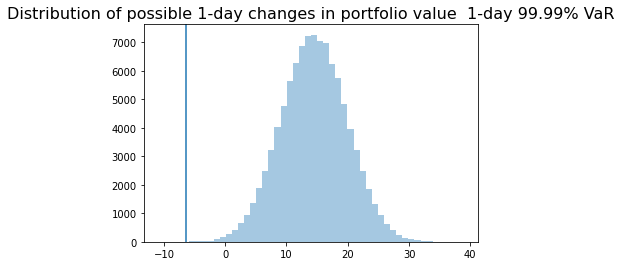

In [60]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value  1-day 99.99% VaR''', fontsize=16)
ax.axvline(var[0], 0, 10000);

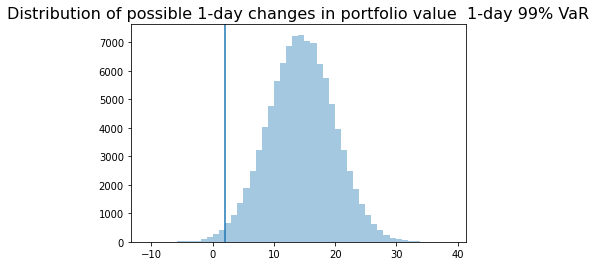

In [58]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value  1-day 99% VaR''', fontsize=16)
ax.axvline(var[2], 0, 10000);

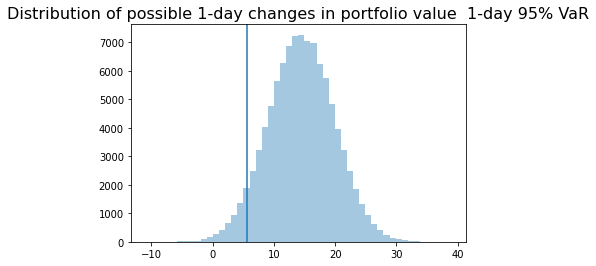

In [59]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value  1-day 95% VaR''', fontsize=16)
ax.axvline(var[3], 0, 10000);